<a href="https://colab.research.google.com/github/StephenSpicer/DS23_Unit01_ProjBuild/blob/main/Edit_PortfolioProject01_Corn_and_Markets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

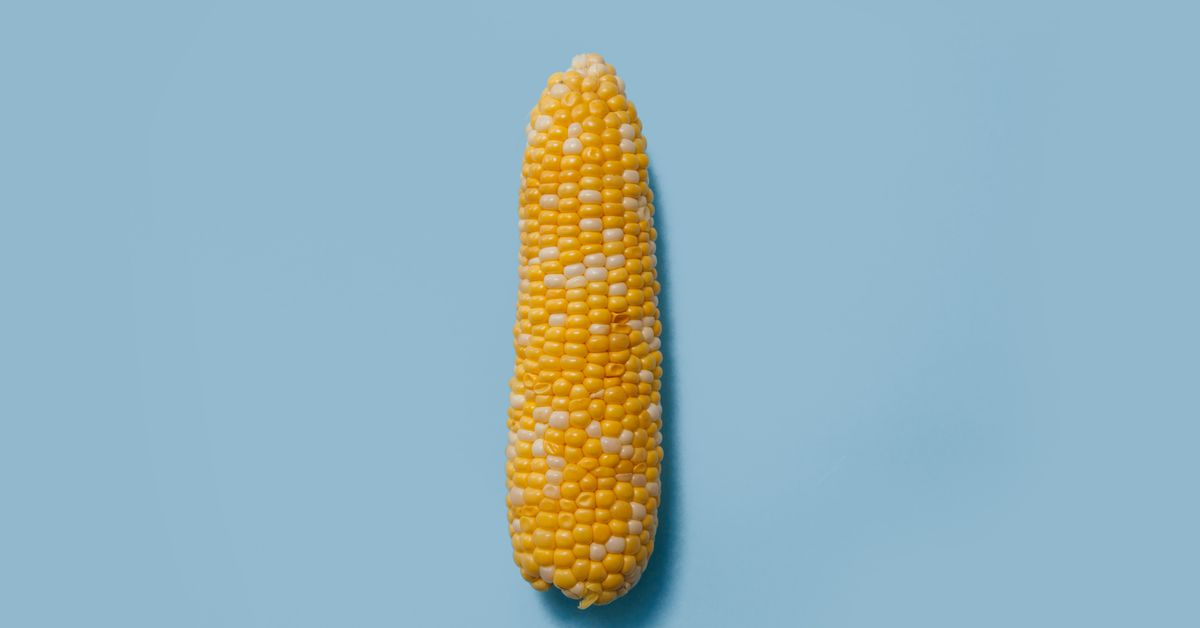

Author : @ Stephen Lupsha
## Lambda Academy Data Science Cohort 23
# **Portfolio Project 01 - Corn and Markets**

# I will be diving into some agricultural and market data. I want to see if I can find a correlation between the price or quantity of Corn produced and the exports markets, USDI, or dow jones for example.

This should be relatively straightforward. I have identified several data sets that should contain what I need to get this going here... all three of these first CSVs come from a google data search / investing.com and are measured on a Monthly basis from 1985 to 2020. 



In [2]:
# First things first, I will import the modules I need. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from numpy.linalg import norm
import seaborn as sns

# That should do it for now, I can return here to the top and add as-needed.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# OK, so let's import our data now. 
# https://docs.google.com/spreadsheets/d/1VkluHU2n0k9N-dFXfheedRpUkHTgu8H35lQrHDyg0lI/edit#gid=564234612
# https://docs.google.com/spreadsheets/d/1FoSYE4m_01e1n-JgA6WwVWZEW2Mq8PZ_SbbjO4lXSUE/edit#gid=2044278670
# https://docs.google.com/spreadsheets/d/1rSVYW9raLfW5xb1TIkzUKpO30nRLJitInkN0slxicp0/edit#gid=362546388

# OK, I have returned here to change these to hyperlinks - way easier than manually re-uploading every time the runtime on google colab resets... 

# This handy dandy code from the internet lets us change the google drive URL so pandas can read the CSV straight from my drive. 

# export?format=csv&gid

# pretty cool right?

dowjones_initial = pd.read_csv('https://docs.google.com/spreadsheets/d/1VkluHU2n0k9N-dFXfheedRpUkHTgu8H35lQrHDyg0lI/export?format=csv&gid=564234612', index_col=0)
cornfutures_initial = pd.read_csv('https://docs.google.com/spreadsheets/d/1FoSYE4m_01e1n-JgA6WwVWZEW2Mq8PZ_SbbjO4lXSUE/export?format=csv&gid=2044278670', index_col=0)
usdindex_initial = pd.read_csv('https://docs.google.com/spreadsheets/d/1rSVYW9raLfW5xb1TIkzUKpO30nRLJitInkN0slxicp0/export?format=csv&gid=362546388', index_col=0)

Before we start displaying these, let me do some linking so we all know what the heck we're talking about here. 

https://www.investing.com/currencies/us-dollar-index-historical-data

The US Dollar Index is used to measure the value of the dollar against a basket of six world currencies - Euro, Swiss Franc, Japanese Yen, Canadian dollar, British pound, and Swedish Krona.
The index was established shortly after the Bretton Woods Agreement dissolved in 1973 with a base of 100, and values since then are relative to this base.
The value of the index is fair indication of the dollar’s value in global markets.


https://www.investing.com/commodities/us-corn-historical-data

Corn has many applications including livestock feed, ethanol, high-fructose corn syrup, corn starch, alcoholic beverages, deodorant, cough drops and more. The price of corn is affected by the ethanol market, crude oil prices, Chinese demand, the US Dollar, and climate.

Also, truth be told corn just "seems" so american to me, I've picked it for this test. 

https://www.investing.com/indices/us-30-historical-data

The Dow Jones Industrial Average, Dow Jones, or simply the Dow, is a stock market index that measures the stock performance of 30 large companies listed on stock exchanges in the United States.

This will make a nice indicator for us about how the markets were doing overall throughout, etc. 

I would love to add Nasdaq and S&P, but let me get through this first test first. 



# Everything has been pulled from the last month of 1985 until December of 2020. 

In [4]:
# First, we will look at the corn futures. 

cornfutures_initial.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
Dec 20,484.12,420.00,484.88,409.00,74.88K,15.34%
Nov 20,419.75,396.00,430.50,393.00,3.52M,5.33%
Oct 20,398.50,379.00,422.25,377.25,4.51M,5.15%
Sep 20,379.00,347.75,382.75,343.25,2.13M,8.75%
Aug 20,348.50,315.00,353.00,307.25,2.75M,10.28%


In [5]:
# Next, the USD Index. 

usdindex_initial.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
Dec 20,89.895,91.890,91.912,89.477,17.25K,-2.14%
Nov 20,91.858,94.095,94.330,91.490,474.40K,-2.32%
Oct 20,94.042,93.865,94.140,92.460,450.49K,0.12%
Sep 20,93.927,92.170,94.795,91.725,489.92K,1.95%
Aug 20,92.131,93.390,93.980,91.990,471.47K,-1.28%


In [6]:
# and finally the dow jones. 
# we may add another market but let's work with what we have for now.

dowjones_initial.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
Dec 20,"30,396.41","29,797.50","30,588.79","29,599.29",296.14M,2.56%
Nov 20,"29,638.64","26,691.28","30,116.51","26,691.28",7.92B,11.84%
Oct 20,"26,501.60","27,940.63","28,957.90","26,143.77",8.51B,-4.61%
Sep 20,"27,781.70","28,439.61","29,199.35","26,537.01",10.05B,-2.28%
Aug 20,"28,430.05","26,542.32","28,733.35","26,534.38",7.51B,7.57%


*OK. We've imported these three CSVs here. Now I may want to make one dataframe that contains all of these three in one, or more specifically the relevant features. So I can copy the price columns from each, and add them to new columns named specifically for category.*

Here's what I'm thinking - I'm only gonna keep price and volume from all 3. We have so many months and years here that for the purposes of this exercise, I think we will prefer to run off of price as a major observation and keep volume around because I'm curious about it - but Open, High, Low, and Change % can all be dropped. So, here we go - let's drop some columns. 

In [7]:
# I wonder what function we will use to drop these columns that we don't need... 

# dowjones_clean = dowjones_initial.drop(dowjones_initial['Open'], dowjones_initial['High'], dowjones_initial['Low'], dowjones_initial['Change %'])

dowjones_clean = dowjones_initial.drop(['Open', 'High', 'Low','Change %'], axis=1 )

# Let's remember to specify specific column names so that when we join these we will know which is which. 

dowjones_clean.rename(columns={'Price':'dji_price', 'Vol.':'dji_vol_in_B'}, inplace=True)
# got to get the commas out of here somehow

dowjones_clean['dji_price'] = (dowjones_clean['dji_price'].replace(',','', regex=True).astype(float))


dowjones_clean['dji_vol_in_B'] = (dowjones_clean['dji_vol_in_B'].replace('K','', regex=True)
                                                                        .replace('M','', regex=True)
                                                                        .replace('B','', regex=True)
                                                                        .astype(float))

# ok, awesome, we got rid of the commas. 

print(dowjones_clean.shape)
print(dowjones_clean.head())

(431, 2)
        dji_price  dji_vol_in_B
Date                           
Dec 20   30396.41        296.14
Nov 20   29638.64          7.92
Oct 20   26501.60          8.51
Sep 20   27781.70         10.05
Aug 20   28430.05          7.51


In [8]:
# now for the USD index

usdindex_clean= usdindex_initial.drop(['Open', 'High', 'Low','Change %'], axis=1 )

# and same
usdindex_clean.rename(columns={'Price':'usd_price', 'Vol.':'usd_vol_in_K'}, inplace=True)
usdindex_clean['usd_vol_in_K'] = (usdindex_clean['usd_vol_in_K'].replace('M','', regex=True)
                                                                        .replace('K','', regex=True)
                                                                        .astype(float))

print(usdindex_clean.shape)
print(usdindex_clean.head())


(421, 2)
        usd_price  usd_vol_in_K
Date                           
Dec 20     89.895         17.25
Nov 20     91.858        474.40
Oct 20     94.042        450.49
Sep 20     93.927        489.92
Aug 20     92.131        471.47


In [9]:
# and finally corn futures. 

cornfutures_clean = cornfutures_initial.drop(['Open', 'High', 'Low','Change %'], axis=1 )

# and the rename

cornfutures_clean.rename(columns={'Price':'corn_price', 'Vol.':'corn_vol_in_M'}, inplace=True)
# cornfutures_clean = cornfutures_clean.iloc[1:]
cornfutures_clean['corn_vol_in_M'] = (cornfutures_clean['corn_vol_in_M'].replace('M','', regex=True)
                                                                        .replace('K','', regex=True)
                                                                        .astype(float))

print(cornfutures_clean.shape)
print(cornfutures_clean.head())


(432, 2)
        corn_price  corn_vol_in_M
Date                             
Dec 20      484.12          74.88
Nov 20      419.75           3.52
Oct 20      398.50           4.51
Sep 20      379.00           2.13
Aug 20      348.50           2.75


# Looks like we should lose December 2020, the first row. Also, going to have to either fillna or trim the two longest to the length of the shortest dataframe.  

Now I think we want to join these three stripped down frames into one frame so that we can run some tests and the OLS model, do some graphs to see whether or not we have some linear relationships, and of course graph those if we find them. We may want to add some other elements, like for example total corn produced. Just thinking out loud for now. 

In [10]:
df_combined = cornfutures_clean.join(usdindex_clean, on='Date')
df_combined = df_combined.join(dowjones_clean, on='Date')

# drop Dec 20
df_combined = df_combined.iloc[1:]
# The above line is really important, we have to lose december because it was throwing off the numbers. I assume because only partial data was available, it doesn't matter - we don't need it. 


df_combined.head(20)

,corn_price,corn_vol_in_M,usd_price,usd_vol_in_K,dji_price,dji_vol_in_B
Date,,,,,,
Nov 20,419.75,3.52,91.858,474.40,29638.64,7.92
Oct 20,398.50,4.51,94.042,450.49,26501.60,8.51
Sep 20,379.00,2.13,93.927,489.92,27781.70,10.05
Aug 20,348.50,2.75,92.131,471.47,28430.05,7.51
Jul 20,316.00,1.45,93.321,432.81,26428.32,8.27
Jun 20,338.50,4.08,97.349,385.76,25812.88,9.82
May 20,325.75,1.37,98.341,305.48,25383.11,8.01
Apr 20,311.50,2.91,99.028,288.23,24345.72,9.88
Mar 20,340.75,2.00,99.092,680.13,21917.16,15.60


# THIS IS IMPORTANT. 

Do not run the below cell more than once or it will keep chopping off the last 11 entries. It should end on Dec 85 - run the above cell again to reset it from the original combined dataframe. 

In [11]:
# DO NOT RUN THIS CELL AGAIN
# also going to take out the last 11 rows. 
df_combined = df_combined.iloc[:-11]
df_combined.tail(10)

,corn_price,corn_vol_in_M,usd_price,usd_vol_in_K,dji_price,dji_vol_in_B
Date,,,,,,
Sep 86,176.75,200.44,107.54,3.78,1767.58,19.89
Aug 86,154.25,132.55,106.72,4.10,1898.34,14.64
Jul 86,165.25,87.78,108.58,10.32,1775.31,16.18
Jun 86,217.25,196.60,112.05,10.10,1892.72,13.20
May 86,237.00,119.82,117.65,18.40,1876.71,15.04
Apr 86,238.25,206.07,112.62,24.45,1783.98,20.84
Mar 86,234.75,95.91,118.08,7.89,1818.61,18.53
Feb 86,228.00,186.66,115.15,14.19,1709.06,18.84
Jan 86,244.00,301.36,121.91,21.75,1570.99,14.95


Alright, we've gotten here. I want to add Import and Export totals for those months but it's proving kind of rough to find that in a usable way without a ton of clicking in excel - can return to that later. 

# we seem to at least have cleaned it up enough to where it's uniform and all floats 



In [12]:
df_combined.describe()

,corn_price,corn_vol_in_M,usd_price,usd_vol_in_K,dji_price,dji_vol_in_B
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000
mean,323.993452,255.234238,92.271695,188.880143,10496.776857,44.421905
std,137.098705,287.170108,10.346541,233.810977,6887.363424,83.099024
min,147.250000,1.000000,72.165000,1.000000,1546.670000,1.480000
25%,225.375000,2.650000,84.427500,30.410000,3841.002500,4.772500
50%,273.875000,179.910000,92.594000,51.640000,10181.185000,14.940000
75%,374.500000,438.470000,98.105000,390.007500,13212.002500,31.092500
max,806.500000,988.750000,123.550000,938.400000,29638.640000,774.500000


# OK, much better. I should probably trim everything down to two decimals though. 

For now, let's dive into some seaborn graphs and OLS things...

In [13]:
# Here comes the OLS model

model_usd_corn = ols('corn_price ~ usd_price', data=df_combined).fit()

print(model_usd_corn.summary())

                            OLS Regression Results                            
Dep. Variable:             corn_price   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     214.0
Date:                Fri, 08 Jan 2021   Prob (F-statistic):           2.01e-39
Time:                        15:06:17   Log-Likelihood:                -2575.3
No. Observations:                 420   AIC:                             5155.
Df Residuals:                     418   BIC:                             5163.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1035.4356     48.940     21.157      0.0

In [14]:
model_corn_dji = ols('corn_price ~ dji_price', data=df_combined).fit()

print(model_corn_dji.summary())


                            OLS Regression Results                            
Dep. Variable:             corn_price   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     85.67
Date:                Fri, 08 Jan 2021   Prob (F-statistic):           1.12e-18
Time:                        15:06:17   Log-Likelihood:                -2623.0
No. Observations:                 420   AIC:                             5250.
Df Residuals:                     418   BIC:                             5258.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    237.8193     11.132     21.364      0.0

In [15]:
model_cornvol_usd = ols('corn_vol_in_M ~ dji_vol_in_B', data=df_combined).fit()

print(model_cornvol_usd.summary())


                            OLS Regression Results                            
Dep. Variable:          corn_vol_in_M   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     60.48
Date:                Fri, 08 Jan 2021   Prob (F-statistic):           5.87e-14
Time:                        15:06:17   Log-Likelihood:                -2944.3
No. Observations:                 420   AIC:                             5893.
Df Residuals:                     418   BIC:                             5901.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      200.6582     14.873     13.492   

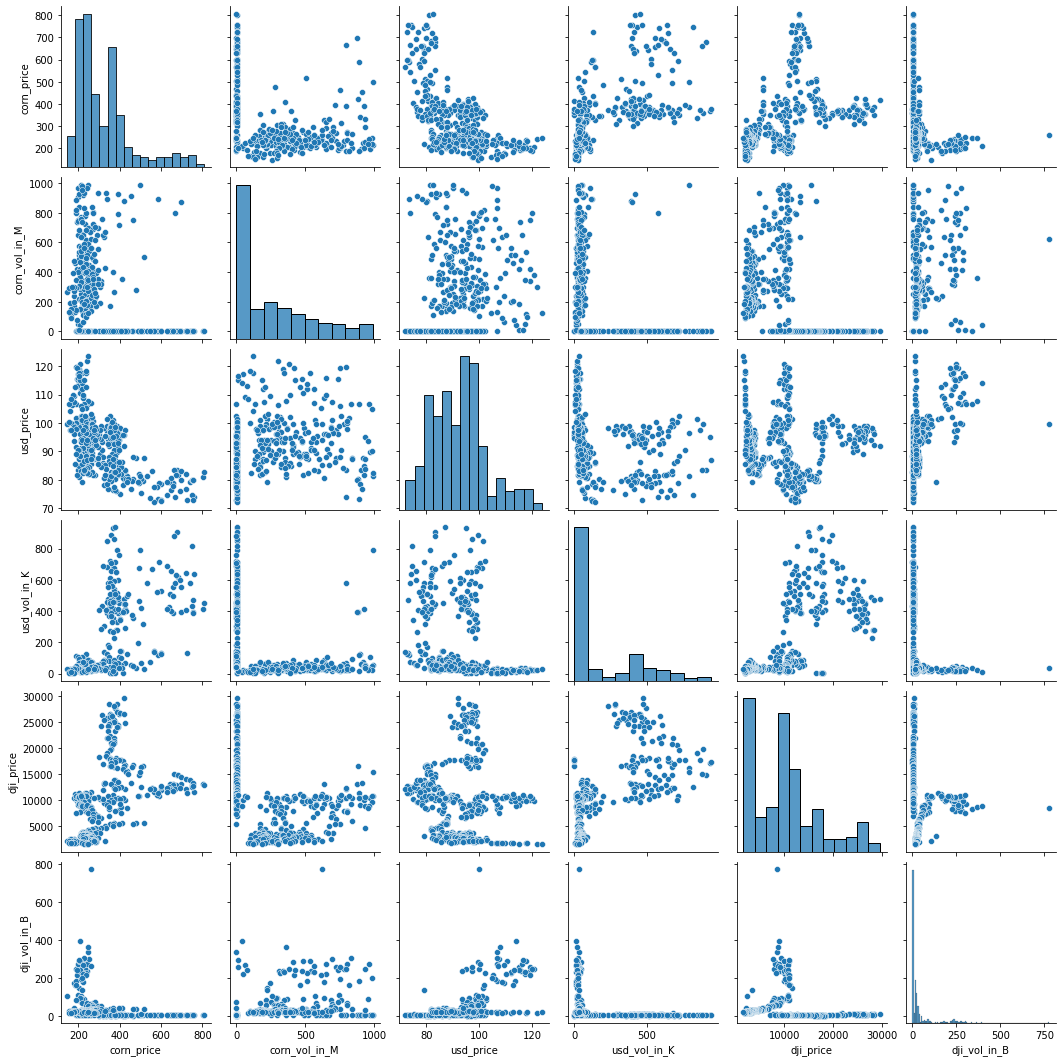

In [16]:
to_plot = df_combined[['corn_price',	'corn_vol_in_M',	'usd_price',	'usd_vol_in_K',	'dji_price',	'dji_vol_in_B']]
sns.pairplot(to_plot)

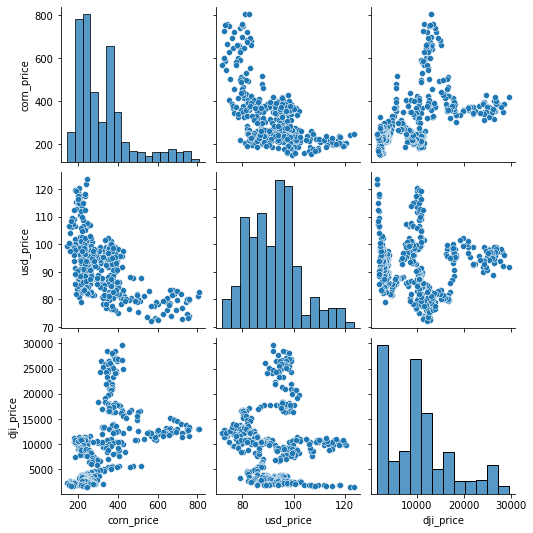

In [17]:
# Let's "Pare" this down a bit ;D

to_plot2 = df_combined[['corn_price', 'usd_price',	'dji_price']]
sns.pairplot(to_plot2)

# ok, so now I can see that there's not much here, let me bring in some other crops or products. I'll start with the S&P 500 for the same time period, and the price of soybean futures. 

In [18]:
# here comes the S&P. Just doing price no volume. 
sp500_price = pd.read_csv('https://docs.google.com/spreadsheets/d/13gzj1jsre6hXnpjEIZZL44q19SU0Ko0Bbwo6FohkON8/export?format=csv&gid=685974898', index_col=0)
sp500_price['S&P_Price'] = (sp500_price['Price'].replace(',','', regex=True).astype(float))
sp500_price = sp500_price.drop('Price', axis=1)

sp500_price.head()

,S&P_Price
Date,
Dec 20,3756.07
Nov 20,3621.63
Oct 20,3269.96
Sep 20,3363.00
Aug 20,3500.31


## This is the cool. google sheets function for number formatting...

---

---




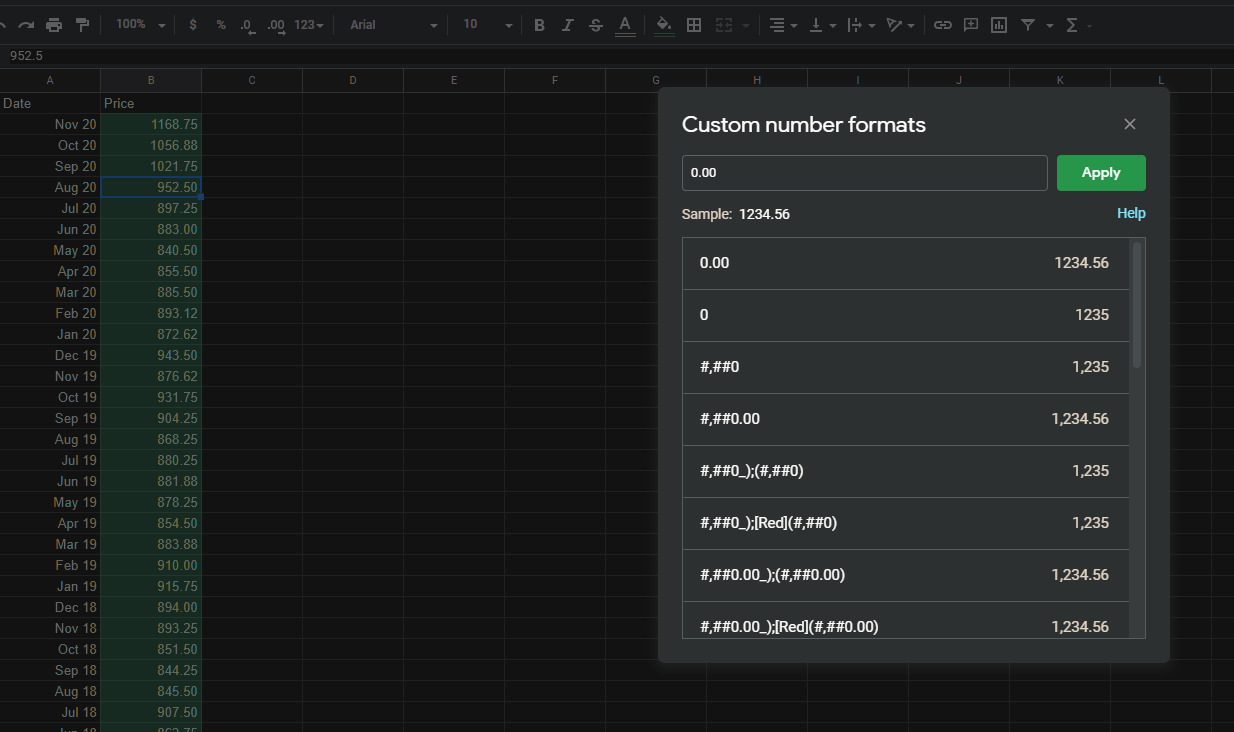

## Anyways, here's the soy. 


In [19]:

soy_price = pd.read_csv('https://docs.google.com/spreadsheets/d/1Wl5C7PM670MqhbhZ9GE3AnUOJg9u6xrGUCrxSbZ5Qr4/export?format=csv&gid=997837311', index_col=0)
soy_price.rename(columns={'Price':'soy_price'}, inplace=True)
soy_price.head()

,soy_price
Date,
Nov 20,1168.75
Oct 20,1056.88
Sep 20,1021.75
Aug 20,952.50
Jul 20,897.25


In [20]:
# let's get some shapes here... 

print("First DataFrame:", df_combined.shape)
print("S&P Shape:", sp500_price.shape)
print("Soy Price Shape:", soy_price.shape)




First DataFrame: (420, 6)
S&P Shape: (421, 1)
Soy Price Shape: (370, 1)


## Do I want to lose 50 years off the bottom just so we have matching shapes? 

In [21]:
# I'm going to add S&P here. 
# first we will strip of Dec 20
# then we will join

sp500_price = sp500_price.iloc[1:]
print(sp500_price.shape)

(420, 1)


In [22]:
sp500_price.head()

,S&P_Price
Date,
Nov 20,3621.63
Oct 20,3269.96
Sep 20,3363.00
Aug 20,3500.31
Jul 20,3271.12


In [23]:
# joining the s&P to our combined dataframe, naming it combined 2

df_combined_2 = df_combined.join(sp500_price, on='Date')

print(df_combined_2.shape)
#Intersting that Print crops the .head() but not applying Print does not crop it. 
df_combined_2.head()

(420, 7)


,corn_price,corn_vol_in_M,usd_price,usd_vol_in_K,dji_price,dji_vol_in_B,S&P_Price
Date,,,,,,,
Nov 20,419.75,3.52,91.858,474.40,29638.64,7.92,3621.63
Oct 20,398.50,4.51,94.042,450.49,26501.60,8.51,3269.96
Sep 20,379.00,2.13,93.927,489.92,27781.70,10.05,3363.00
Aug 20,348.50,2.75,92.131,471.47,28430.05,7.51,3500.31
Jul 20,316.00,1.45,93.321,432.81,26428.32,8.27,3271.12


# Now We're going to add logs and the actual "digits" instead of accounting for the millions billions thousands etc. Let's just see what happens. 


## Shouldn't take too long... famous last words. 




In [24]:
# import numpy as np
# sleep['Log_brain'] = np.log(sleep['Brain'])


df_combined_2['log_usdprice'] = np.log(df_combined_2['usd_price'])
df_combined_2['log_cornprice'] = np.log(df_combined_2['corn_price'])

df_combined_2.head()

,corn_price,corn_vol_in_M,usd_price,usd_vol_in_K,dji_price,dji_vol_in_B,S&P_Price,log_usdprice,log_cornprice
Date,,,,,,,,,
Nov 20,419.75,3.52,91.858,474.40,29638.64,7.92,3621.63,4.520244,6.039659
Oct 20,398.50,4.51,94.042,450.49,26501.60,8.51,3269.96,4.543741,5.987707
Sep 20,379.00,2.13,93.927,489.92,27781.70,10.05,3363.00,4.542518,5.937536
Aug 20,348.50,2.75,92.131,471.47,28430.05,7.51,3500.31,4.523211,5.853638
Jul 20,316.00,1.45,93.321,432.81,26428.32,8.27,3271.12,4.536045,5.755742


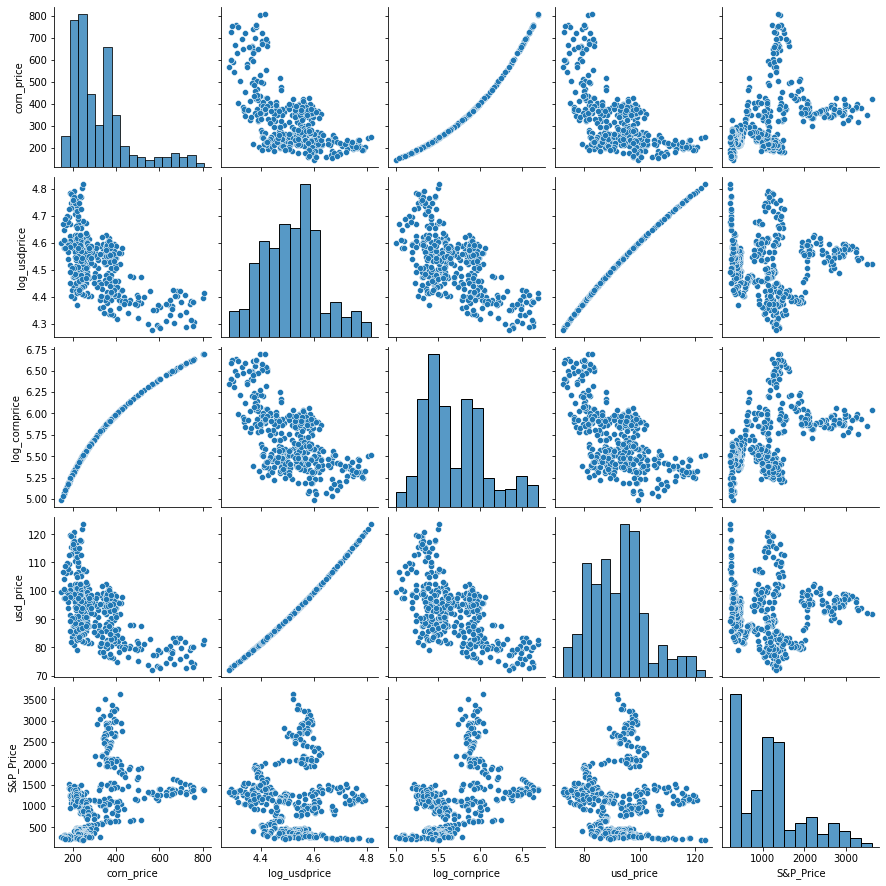

In [25]:
# Let's see here, fingers crossed. 
to_plot3 = df_combined_2[['corn_price', 'log_usdprice', 'log_cornprice', 'usd_price', 'S&P_Price']]
sns.pairplot(to_plot3)

Let's see what else we can bring in. 

In [26]:
# Why not a third dataframe with 50 fewer months that also has soy. Here we go. 

df_combined3_soy = df_combined_2.iloc[:-50]
df_combined3_soy = df_combined3_soy.join(soy_price)
print(df_combined3_soy.shape)
df_combined3_soy.head()

(370, 10)


,corn_price,corn_vol_in_M,usd_price,usd_vol_in_K,dji_price,dji_vol_in_B,S&P_Price,log_usdprice,log_cornprice,soy_price
Date,,,,,,,,,,
Nov 20,419.75,3.52,91.858,474.40,29638.64,7.92,3621.63,4.520244,6.039659,1168.75
Oct 20,398.50,4.51,94.042,450.49,26501.60,8.51,3269.96,4.543741,5.987707,1056.88
Sep 20,379.00,2.13,93.927,489.92,27781.70,10.05,3363.00,4.542518,5.937536,1021.75
Aug 20,348.50,2.75,92.131,471.47,28430.05,7.51,3500.31,4.523211,5.853638,952.50
Jul 20,316.00,1.45,93.321,432.81,26428.32,8.27,3271.12,4.536045,5.755742,897.25


In [27]:
# Alright. That's the correct number of rows to involve ALL of soy prices, so let's do another pairplot. 

# Actually I'll add a log of soy just to see what happens. 

df_combined3_soy['log_soy'] = np.log(df_combined3_soy['soy_price'])
df_combined3_soy.head()

,corn_price,corn_vol_in_M,usd_price,usd_vol_in_K,dji_price,dji_vol_in_B,S&P_Price,log_usdprice,log_cornprice,soy_price,log_soy
Date,,,,,,,,,,,
Nov 20,419.75,3.52,91.858,474.40,29638.64,7.92,3621.63,4.520244,6.039659,1168.75,7.063690
Oct 20,398.50,4.51,94.042,450.49,26501.60,8.51,3269.96,4.543741,5.987707,1056.88,6.963076
Sep 20,379.00,2.13,93.927,489.92,27781.70,10.05,3363.00,4.542518,5.937536,1021.75,6.929272
Aug 20,348.50,2.75,92.131,471.47,28430.05,7.51,3500.31,4.523211,5.853638,952.50,6.859090
Jul 20,316.00,1.45,93.321,432.81,26428.32,8.27,3271.12,4.536045,5.755742,897.25,6.799335


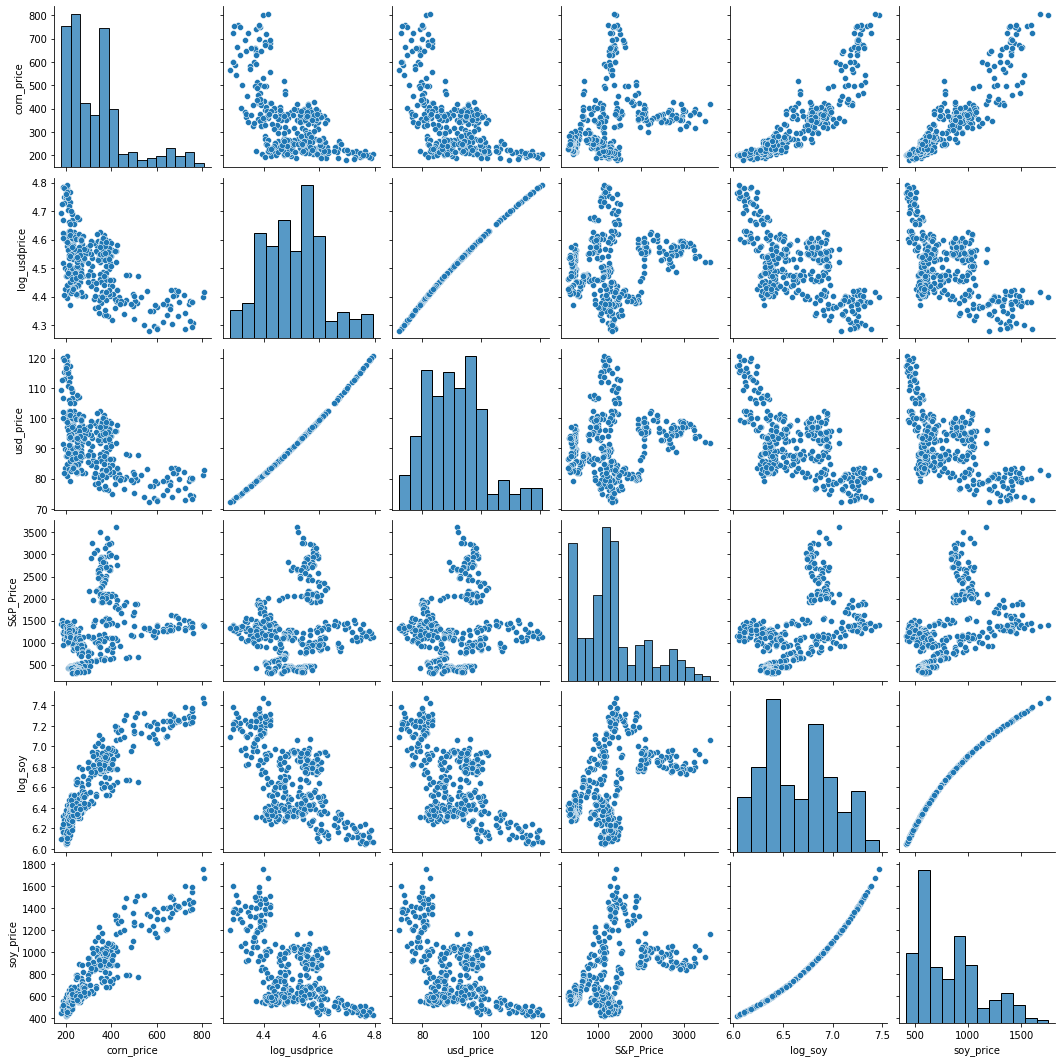

In [28]:
to_plot4 = df_combined3_soy[['corn_price', 'log_usdprice', 'usd_price', 'S&P_Price', 'log_soy', 'soy_price']]
sns.pairplot(to_plot4)

## Bringing in some new data here. 


In [29]:
# Let's recall that handy dandy google drive URL replacement string 
# export?format=csv&gid

df_goldfutures = pd.read_csv('https://docs.google.com/spreadsheets/d/1jYDjQoGjX2MumofBDKdIL7PlsIT_Wr_VaqZzHSyKJYo/export?format=csv&gid=840568569', index_col=0)

# Nice, it's coming in 'LIVE' off that hyperlink. Let's keep going. 

df_wheat = pd.read_csv('https://docs.google.com/spreadsheets/d/1F796nhm3Z-H1SnjfJXNoJYNm2-QiYKKwfefHpmBKCoY/export?format=csv&gid=1670532576', index_col=0)

### It is still working, so let's keep going.  What I'm going to do is join these below as we read them in, so that I don't get ahead of myself as we go through this list of new CSV's to test etc...

df_crude_oil_WTI = pd.read_csv('https://docs.google.com/spreadsheets/d/1CyWZGe0YUAqIvbyGpmz_YydeOa1CKqsK4-p7e-UQae4/export?format=csv&gid=635138984', index_col=0)
df_brent_oil = pd.read_csv('https://docs.google.com/spreadsheets/d/1ogH8O06xn8QssS0boeYKGx4QK-4-LYk-Z2zqtdyq7Bk/export?format=csv&gid=1312419138', index_col=0)
df_invesco_globalcleanETF = pd.read_csv('https://docs.google.com/spreadsheets/d/1ejcGUnvw81zao0driP1sziQQSRZYCf73JCoe-ykv1v8/export?format=csv&gid=872877095', index_col=0)
df_FSDAX_defenseETF = pd.read_csv('https://docs.google.com/spreadsheets/d/14Qb6Hz9B0azd72rPEoEAxZFQnvUtvDxU-xExUc-rbuM/export?format=csv&gid=1804016247', index_col=0)
df_XAR_defenseETF = pd.read_csv('https://docs.google.com/spreadsheets/d/1b-Mo9DBxET4bc7TWvSp1Qtr2wZY3u6h4Wo6pp2Amh_U/export?format=csv&gid=2048759224', index_col=0)
df_archerdanielsmidland_ADM = pd.read_csv('https://docs.google.com/spreadsheets/d/1QXh9k_ch9j0JRmeF_bbsXJzUhv2YkBxpRr0oBi52THE/export?format=csv&gid=1631122716', index_col=0)
df_tysonfoods = pd.read_csv('https://docs.google.com/spreadsheets/d/1ti4vEXM_QxfW_XTECdkS69fZ9DoD1SjFfxzsDAGw6EM/export?format=csv&gid=130644118', index_col=0)


print(df_brent_oil.shape)
print(df_brent_oil.head())
print()
print(df_crude_oil_WTI.shape)
print(df_crude_oil_WTI.head())
print()
print(df_goldfutures.shape)
print(df_goldfutures.head())
print()
print(df_wheat.shape)
print(df_wheat.head())
print()
print(df_invesco_globalcleanETF.shape)
print(df_invesco_globalcleanETF.head())
print()
print(df_FSDAX_defenseETF.shape)
print(df_FSDAX_defenseETF.head())
print()
print(df_XAR_defenseETF.shape)
print(df_XAR_defenseETF.head())
print()
print(df_archerdanielsmidland_ADM.shape)
print(df_archerdanielsmidland_ADM.head())
print()
print(df_tysonfoods.shape)
print(df_tysonfoods.head())

(389, 1)
        brent_oil_price
Date                   
Nov 20            47.59
Oct 20            37.46
Sep 20            40.95
Aug 20            45.28
Jul 20            43.30

(420, 1)
        crude_WTI_price
Date                   
Nov 20            45.34
Oct 20            35.79
Sep 20            40.22
Aug 20            42.61
Jul 20            40.27

(420, 1)
        gold_futures_price
Date                      
Nov 20              1780.9
Oct 20              1887.2
Sep 20              1902.6
Aug 20              1986.5
Jul 20              1995.6

(370, 1)
        wheat_futures_price
Date                       
Nov 20               581.00
Oct 20               598.50
Sep 20               578.12
Aug 20               546.50
Jul 20               531.00

(161, 2)
        invesco_clean_price invesco_clean_vol_inK
Date                                             
Nov 20                30.08                345.01
Oct 20                22.97                168.02
Sep 20                21.94   

In [30]:
print(df_goldfutures.shape)
print(df_wheat.shape)
print(df_combined3_soy.shape)

(420, 1)
(370, 1)
(370, 11)


In [31]:
# Alright, it's clear which ones we can and can-not include at that 370 length threshold. 

df_secondvariables_combined = df_combined3_soy.join(df_wheat, on='Date')
df_secondvariables_combined = df_secondvariables_combined.join(df_goldfutures, on='Date')
df_secondvariables_combined = df_secondvariables_combined.join(df_crude_oil_WTI, on='Date')
df_secondvariables_combined = df_secondvariables_combined.join(df_brent_oil, on='Date')
df_secondvariables_combined = df_secondvariables_combined.join(df_archerdanielsmidland_ADM, on='Date')
df_secondvariables_combined = df_secondvariables_combined.join(df_tysonfoods, on='Date')

NEXT UP 

In [32]:
print(df_secondvariables_combined.shape)
df_secondvariables_combined.head()

(370, 17)


,corn_price,corn_vol_in_M,usd_price,usd_vol_in_K,dji_price,dji_vol_in_B,S&P_Price,log_usdprice,log_cornprice,soy_price,log_soy,wheat_futures_price,gold_futures_price,crude_WTI_price,brent_oil_price,adm_price,tsn_price
Date,,,,,,,,,,,,,,,,,
Nov 20,419.75,3.52,91.858,474.40,29638.64,7.92,3621.63,4.520244,6.039659,1168.75,7.063690,581.00,1780.9,45.34,47.59,49.77,65.20
Oct 20,398.50,4.51,94.042,450.49,26501.60,8.51,3269.96,4.543741,5.987707,1056.88,6.963076,598.50,1887.2,35.79,37.46,46.24,57.23
Sep 20,379.00,2.13,93.927,489.92,27781.70,10.05,3363.00,4.542518,5.937536,1021.75,6.929272,578.12,1902.6,40.22,40.95,46.49,59.48
Aug 20,348.50,2.75,92.131,471.47,28430.05,7.51,3500.31,4.523211,5.853638,952.50,6.859090,546.50,1986.5,42.61,45.28,44.76,62.80
Jul 20,316.00,1.45,93.321,432.81,26428.32,8.27,3271.12,4.536045,5.755742,897.25,6.799335,531.00,1995.6,40.27,43.30,42.83,61.45


## ALRIGHT 


# We are currently NOT looking at... XAR, FSDAX, or INVESCO




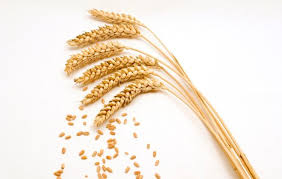

# We've got to see about this oil coming in here. 

In [33]:
# This kicks out a big pairplot that isn't super useful. We'll try again below. 

to_plot5 = df_secondvariables_combined[['corn_price', 'dji_price', 'usd_price', 'S&P_Price', 'soy_price', 'crude_WTI_price', 'brent_oil_price', 'adm_price', 'tsn_price', 'gold_futures_price', 'wheat_futures_price']]
# sns.pairplot(to_plot5)

In [34]:
# also turning off this pairplot for now just to save space. 

to_plot6 = df_secondvariables_combined[['corn_price', 'corn_vol_in_M', 'log_cornprice', 'soy_price', 'adm_price', 'tsn_price', 'gold_futures_price', 'wheat_futures_price']]
#sns.pairplot(to_plot6)

# Promising Pairs include : 

## Wheat futures to corn price 
## Wheat futures to soy price. 
## Corn Price and Soy price. 


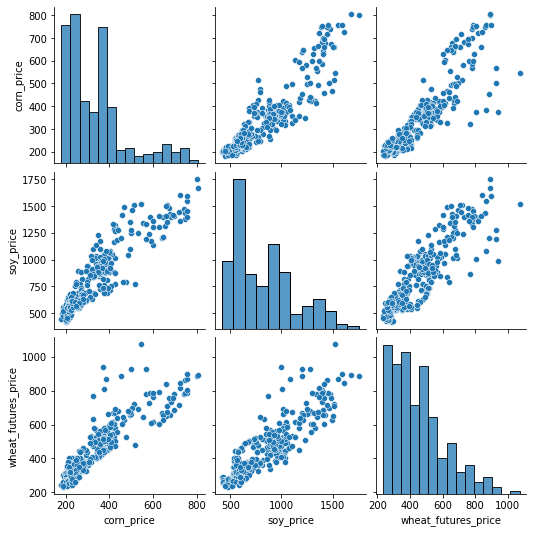

In [35]:
to_plot7 = df_secondvariables_combined[['corn_price', 'soy_price', 'wheat_futures_price']]

sns.pairplot(to_plot7)

# OK, there's some alright slopes to work with there. 

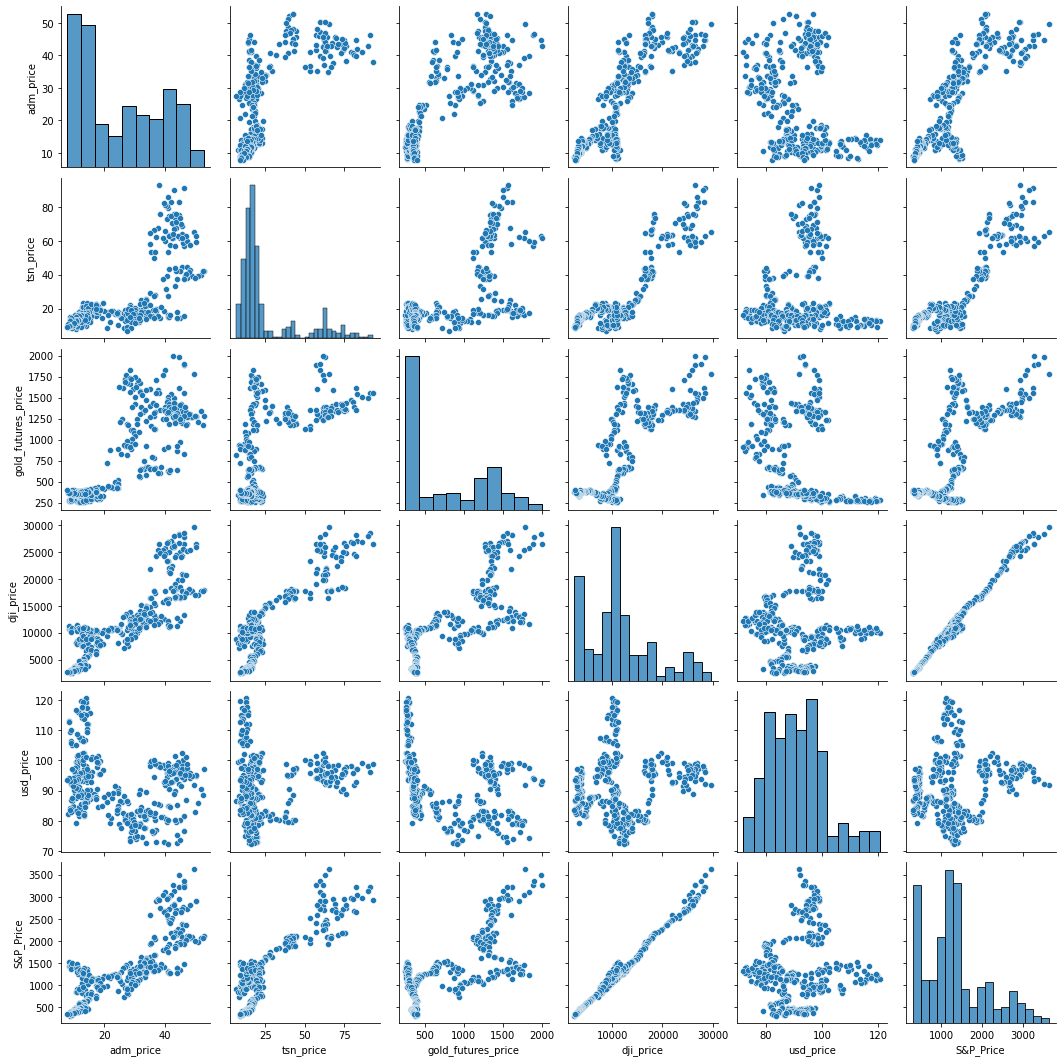

In [36]:
# Ok, going back one more time for two big ag dependent stocks, gold futures, and the three market indicators we picked DJI, S&P and USDI. 

to_plot8 = df_secondvariables_combined[['adm_price', 'tsn_price', 'gold_futures_price', 'dji_price', 'usd_price', 'S&P_Price']]

sns.pairplot(to_plot8)

## I wanna show S&P for Tyson and ADM.
## Also DJI for Tyson and ADM. 
## No reason I can see to do DJI and S&P together, at least not with this type of dataset.  
## Gold looks like nothing. 

# **Let's get some regplots going and ols models from the last two pairplots we did.** 

In [37]:
df_secondvariables_combined = df_secondvariables_combined.dropna()

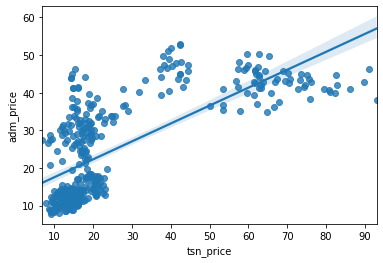

In [38]:
ax = sns.regplot(x="tsn_price", y="adm_price", data=df_secondvariables_combined, ci=95)

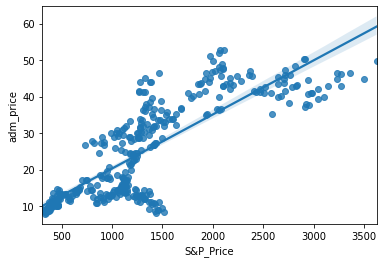

In [47]:
ax = sns.regplot(x="S&P_Price", y="adm_price", data=df_secondvariables_combined, ci=95)

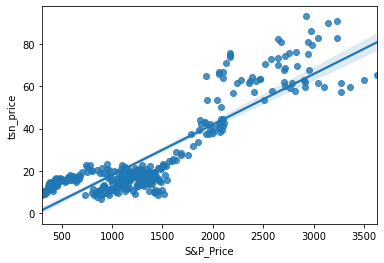

In [40]:
ax = sns.regplot(x="S&P_Price", y="tsn_price", data=df_secondvariables_combined, ci=95)

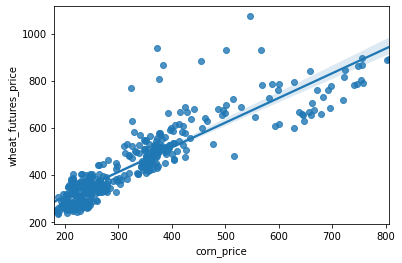

In [41]:
ax = sns.regplot(x="corn_price", y="wheat_futures_price", data=df_secondvariables_combined, ci=95)

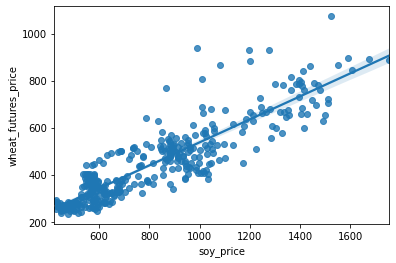

In [42]:
ax = sns.regplot(x="soy_price", y="wheat_futures_price", data=df_secondvariables_combined, ci=95)

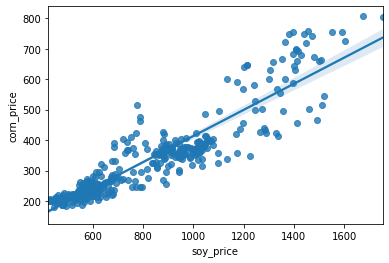

In [43]:
ax = sns.regplot(x="soy_price", y='corn_price', data=df_secondvariables_combined, ci=95)

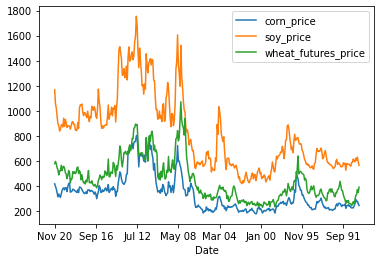

In [44]:
df_secondvariables_trim = df_secondvariables_combined[['corn_price', 'soy_price', 'wheat_futures_price']]
lines = df_secondvariables_trim.plot.line()

In [45]:
print("Thanks for reading")

Thanks for reading


In [46]:
# Be Grateful 